In [1]:
import striplog 

striplog.__version__

'0.8.7'

# Blocking curves with `welly` and `striplog`

Let's load a well from an LAS File using `welly`:

In [2]:
from welly import Well

w = Well.from_las('P-129_out.LAS')

w

Found nonstandard LAS section: ~Parameter
/home/matt/anaconda3/envs/welly/lib/python3.8/site-packages/welly/well.py:194: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


Well(uwi: 'Long = 63* 45'24.460  W', 24 curves: ['CALI', 'HCAL', 'PEF', 'DT', 'DTS', 'DPHI_SAN', 'DPHI_LIM', 'DPHI_DOL', 'NPHI_SAN', 'NPHI_LIM', 'NPHI_DOL', 'RLA5', 'RLA3', 'RLA4', 'RLA1', 'RLA2', 'RXOZ', 'RXO_HRLT', 'RT_HRLT', 'RM_HRLT', 'DRHO', 'RHOB', 'GR', 'SP'])

In [3]:
gr = w.data['GR']

gr

Curve([46.69865036, 46.69865036, 46.69865036, ..., 92.24622345,
       92.24622345, 92.24622345])

We can block this log based on some cutoffs:

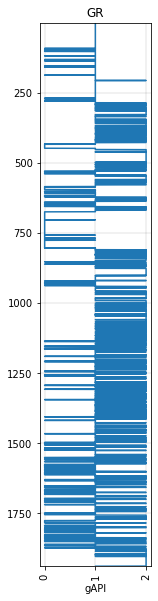

In [4]:
gr_blocky = gr.block(cutoffs=[40, 100])

gr_blocky.plot()

But now we're not really dealing with regularly-sampled data anymore, we're dealing with 'intervals'. **Striplog** is sometimes a better option for representing this sort of data. So let's try using that instead:

## Make a striplog instead of a blocked log

Striplog objects are potentially a bit more versatile than trying to use a log to represent intervals.

We have to do a little extra work though; for example, we have to tell Striplog what the intervals represent... the contents (lithologies or whatever) of an interval are called 'components'.

We also have to pass the depth separately, because Striplog doesn't know anything about welly's `Curve` objects.

In [5]:
from striplog import Striplog, Component

comps = [
    Component(properties={'lithology': 'sandstone'}),
    Component(properties={'lithology': 'siltstone'}),
    Component(properties={'lithology': 'shale'}),
]

s = Striplog.from_log(gr, basis=gr.basis, cutoff=[40, 100], components=comps)

s

Striplog(853 Intervals, start=1.0668, stop=1939.1376000000012)

You can plot this:

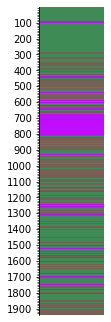

In [6]:
s.plot(aspect=3)

For a more natural visualization, it's a good idea to make a legend to display things. For example:

In [7]:
from striplog import Legend

L = """comp lithology, colour, width, curve mnemonic
       sandstone, #fdf43f, 3
       siltstone, #cfbb8f, 2
       shale, #c0d0c0, 1
"""

legend = Legend.from_csv(text=L)

legend

Legend(Decor({'_colour': '#fdf43f', 'width': 3.0, 'component': Component({'lithology': 'sandstone'}), 'hatch': None})
Decor({'_colour': '#cfbb8f', 'width': 2.0, 'component': Component({'lithology': 'siltstone'}), 'hatch': None})
Decor({'_colour': '#c0d0c0', 'width': 1.0, 'component': Component({'lithology': 'shale'}), 'hatch': None}))

Now the plot will look more geological:

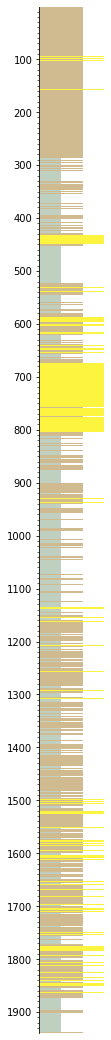

In [8]:
s.plot(legend=legend)

Let's simplify it a bit by removing beds thinner than 3 m, then 'annealing' over the gaps, then merging like neighbours (otherwise you'll likely have a lot of beds juxtaposed with similar beds):

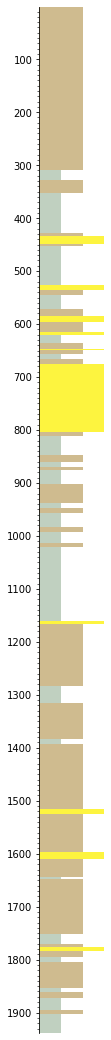

In [9]:
s = s.prune(limit=3).anneal().merge_neighbours()

s.plot(legend=legend)

The easiest way to plot with a curve is like:

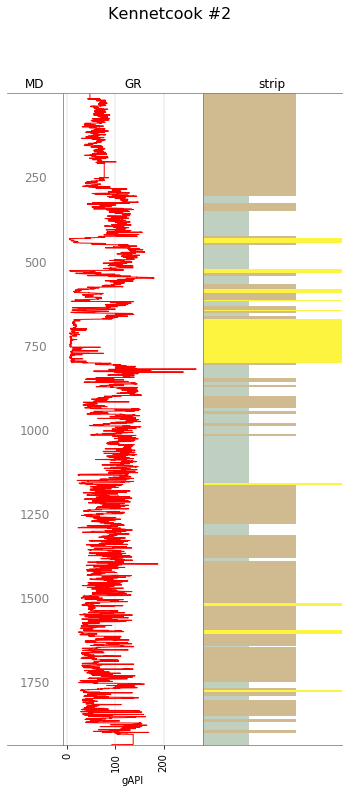

In [10]:
w.data['strip'] = s

tracks = ['MD', 'GR', 'strip']

C = """curve mnemonic, colour, width
       GR, #ff0000, 1
       GR-B, #ff8800, 1
"""

curve_legend = Legend.from_csv(text=C)

big_legend = legend + curve_legend

w.plot(tracks=tracks, legend=big_legend)

You can still make a blocky version:

(2000, 0)

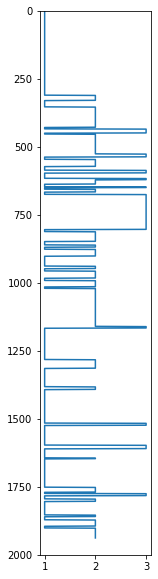

In [11]:
gr_blocky, depth, comps = s.to_log(return_meta=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))
plt.plot(gr_blocky, depth)
plt.ylim(2000, 0)

Note that this is a NumPy array, because `striplog` doesn't know about `welly`. But you could make a `welly.Curve` object:

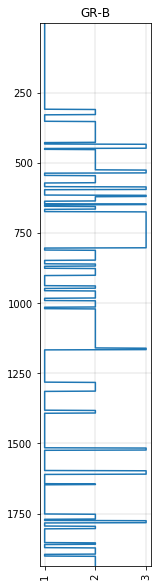

In [12]:
from welly import Curve

gr_blocky = Curve(gr_blocky, basis=depth, params={'mnemonic': 'GR-B'})

gr_blocky.plot()

Let's add this Curve to the well object `w` &mdash; then we can make a multi-track plot with `welly`:

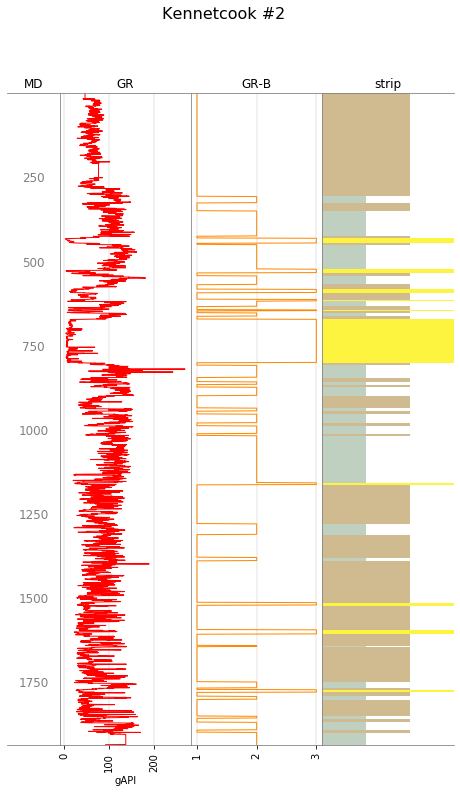

In [13]:
w.data['GR-B'] = gr_blocky

tracks = ['MD', 'GR', 'GR-B', 'strip']

w.plot(tracks=tracks, legend=big_legend)

## Blocking another log using these intervals

Here's the RHOB log:

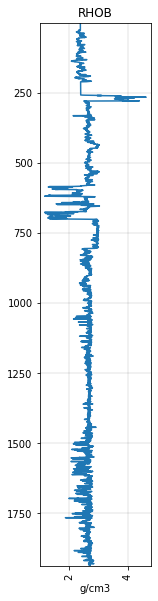

In [14]:
rhob = w.data['RHOB']

rhob.plot()

Now we will 'extract' the RHOB data, using some reducing function &mdash; the default is to take the mean of the interval &mdash; into the intervals of the striplog `s`:

⚠️ Note that since v0.8.7 this returns a copy; before that, it worked **in place**.

In [15]:
import numpy as np

s = s.extract(rhob, basis=rhob.basis, name='RHOB', function=np.median)

Now each interval contains the mean RHOB value from that interval:

In [16]:
s[0]

Interval({'top': Position({'middle': 1.0668, 'units': 'm'}), 'base': Position({'middle': 309.3720000000002, 'units': 'm'}), 'description': '', 'data': {'RHOB': 2.3988199234}, 'components': [Component({'lithology': 'siltstone'})]})

We can now turn that data 'field' into a log, as we did before. This time, however, we can keep the data as the value of the log &mdash; i.e. instead of having 'bins' from the cutoff (like 1, 2, 3, etc), we want the actual value from an interval (i.e. a density in units of g/cm<sup>3</sup>). To get this, we pass `bins=False`.

In [17]:
rhob_blocky, depth, _ = s.to_log(field='RHOB', bins=False, return_meta=True)

We can plot this...

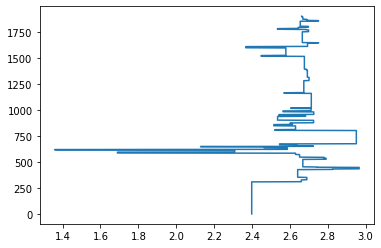

In [18]:
plt.plot(rhob_blocky, depth)

...but it's more useful to make it into a `Curve` object and store it in the well object `w`:

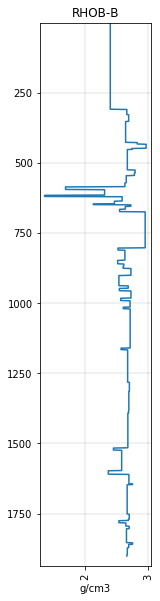

In [19]:
rhob_blocky = Curve(rhob_blocky, basis=depth, params={'mnemonic': 'RHOB-B', 'units': 'g/cm3'})

w.data['RHOB-B'] = rhob_blocky

rhob_blocky.plot()

Now let's plot it next to the blocky GR to verify that the blocks are the same:

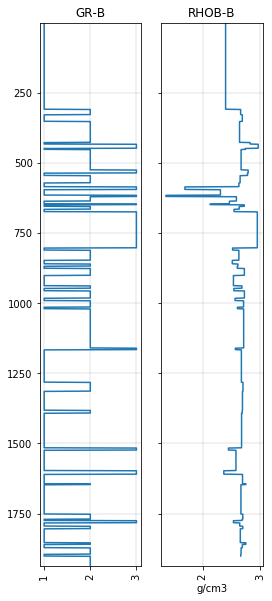

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(4, 10), sharey=True)
gr_blocky.plot(ax=axs[0])
rhob_blocky.plot(ax=axs[1])

Or we can plot everything together using `welly` (if we first extend the legend again to accommodate the new logs):

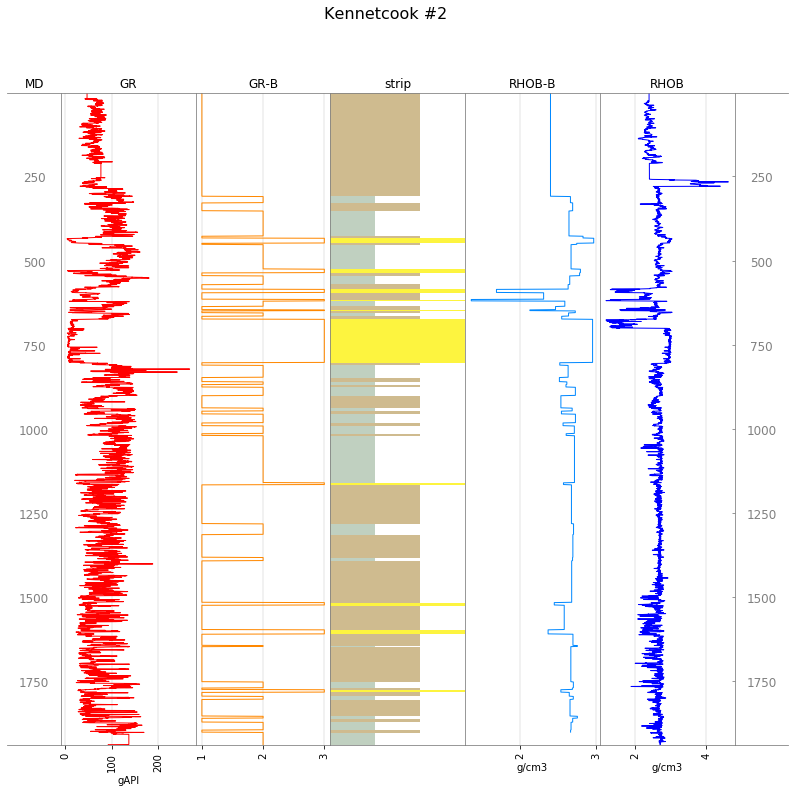

In [21]:
C = """curve mnemonic, colour, width
       GR, #ff0000, 1
       GR-B, #ff8800, 1
       RHOB, #0000ff, 1
       RHOB-B, #0088ff, 1
"""

curve_legend = Legend.from_csv(text=C)

big_legend = legend + curve_legend

tracks = ['MD', 'GR', 'GR-B', 'strip', 'RHOB-B', 'RHOB', 'MD']

w.plot(tracks=tracks, legend=big_legend)

----
&copy; 2020 Agile Scientific, licenced CC-BY.